In [ ]:
import sys
import numpy as np
import pandas as pd

import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

In [ ]:
!unzip input.zip

Archive:  input.zip
   creating: content/input/
   creating: content/input/058/
  inflating: content/input/058/1.bmp  
  inflating: content/input/058/3.bmp  
  inflating: content/input/058/2.bmp  
  inflating: content/input/058/4.bmp  
  inflating: content/input/058/5.bmp  
  inflating: content/input/058/6.bmp  
   creating: content/input/032/
  inflating: content/input/032/1.bmp  
  inflating: content/input/032/3.bmp  
  inflating: content/input/032/2.bmp  
  inflating: content/input/032/4.bmp  
  inflating: content/input/032/5.bmp  
  inflating: content/input/032/6.bmp  
   creating: content/input/034/
  inflating: content/input/034/1.bmp  
  inflating: content/input/034/3.bmp  
  inflating: content/input/034/2.bmp  
  inflating: content/input/034/4.bmp  
  inflating: content/input/034/5.bmp  
  inflating: content/input/034/6.bmp  
   creating: content/input/017/
  inflating: content/input/017/1.bmp  
  inflating: content/input/017/3.bmp  
  inflating: content/input/017/2.bmp  
  inf

In [ ]:
os.mkdir("training")
os.mkdir("testing")


In [ ]:
import glob,shutil
from random import randint
train_path="/content/training/"
test_path="/content/testing/"
for img in glob.glob("/content/content/input/**"):
  # print("kkkkkkkkkkkkkkkkkkkkkkkk",img)
  os.mkdir(os.path.join(train_path,img.split("/")[-1]))
  os.mkdir(os.path.join(test_path,img.split("/")[-1]))
  value = randint(1, 6)
  # print(value)
  for imge in glob.glob(img+"/*"):
    # print(imge.split("/")[-1])
    if str(value) in imge.split("/")[-1]:
      # print("aaaaaaaaaaaaaaa",imge,train_path+img.split("/")[-1]+"/"+imge.split("/")[-1])
      shutil.move(imge,test_path+img.split("/")[-1]+"/"+imge.split("/")[-1])
    else:
      shutil.move(imge,train_path+img.split("/")[-1]+"/"+imge.split("/")[-1])
      
    #   shutil.move(imge,train_path+img.split("/")[-1]+"/"+imge.split("/")[-1])
  



2
6
5
4
1
5
1
5
3
3
2
1
4
5
3
6
1
3
2
5
4
5
2
5
1
4
4
4
6
2
6
1
4
1
2
1
4
4
1
4
3
4
1
4
1
3
3
6
5
1
6
3
4
5
1
2
3
6
6
4
3
4
5
3
2
4
3
1
2
3
3
5
4
6
1
1
4
4
6
6
5
1
1
6
3
6
4
6
2
3
6
5
3
2
3
5
5
5
1
1


In [ ]:
import PIL,glob
def format_data(path):
    X=[]
    y=[]
    # print(path)
    for img in sorted(glob.glob(path+"/**")):
      # print(img)
      current_y=img.split("/")[-1]
      # print("current y",current_y)
      category_images=[]
      for imge in sorted(glob.glob(img+"/*")):
        # print(imge)
        image = (np.asarray(PIL.Image.open(imge).convert('L')))
        # print("imageee",image)
        image= image[10:120, 10:120]
        # print("croppeedddd",image,image.shape)
        category_images.append(image)
        y.append(current_y)
      X.append(np.stack(category_images))
    y = np.vstack(y)
    X = np.stack(X)
    return X,y

In [ ]:
X_train,y_train = format_data("/content/training")
X_test,y_test = format_data("/content/testing")

In [ ]:
print(X_train.shape)
print(y_train.shape)

(100, 5, 110, 110)
(500, 1)


In [ ]:
def euclidean_dist(vect):
    x, y = vect
    sum_square = K.sum(K.square(x-y), axis = 1, keepdims = True)
    result = K.maximum(sum_square, K.epsilon())
    return result

In [ ]:
def weights(shape,name=None,dtype=None):
    return np.random.normal(loc=0.0,scale=1e-2,size=shape)

def bias(shape,name=None, dtype=None):
  return np.random.normal(loc=0.5,scale=1e-2,size=shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Lambda, Input, Flatten, Dense, Concatenate, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import model_from_json
import tensorflow.keras.backend as K
from statistics import mean
def get_model(input_shape):

        # W_init_1 = RandomNormal(mean=0, stddev=0.01)
        # b_init = RandomNormal(mean=0.5, stddev = 0.01)
        # W_init_2 = RandomNormal(mean=0, stddev=0.2)
      
        left_input = Input(input_shape)
        right_input = Input(input_shape)

        convnet = Sequential()
        convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape, kernel_initializer=weights, bias_initializer = bias ,kernel_regularizer=l2(2e-4)))
        convnet.add(MaxPooling2D())
        convnet.add(Conv2D(128,(7,7),activation='relu', kernel_initializer=weights, bias_initializer = bias ,kernel_regularizer=l2(2e-4)))
        convnet.add(MaxPooling2D())
        convnet.add(Conv2D(128,(4,4),activation='relu', kernel_initializer=weights, bias_initializer = bias ,kernel_regularizer=l2(2e-4)))
        convnet.add(MaxPooling2D())
        convnet.add(Conv2D(256,(4,4),activation='relu', kernel_initializer=weights, bias_initializer = bias ,kernel_regularizer=l2(2e-4)))
        convnet.add(MaxPooling2D())
        convnet.add(Flatten())
        convnet.add(Dense(4096,activation="sigmoid", kernel_initializer=weights, bias_initializer = bias ,kernel_regularizer=l2(1e-3)))
        encoded_l = convnet(left_input)
        encoded_r = convnet(right_input)

        # L1_layer = Lambda(lambda tensors:K.abs(tensors[0]-tensors[1]))
        # L1_distance=L1_layer([encoded_l,encoded_r])
        
        # prediction=Dense(1,activation='sigmoid',bias_initializer=bias)(L1_distance)
        # siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

        merge_layer = Lambda(euclidean_dist)([encoded_l,encoded_r])
        prediction = Dense(1,activation='sigmoid')(merge_layer)
        siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
        return siamese_net


In [ ]:
siamese_model=get_model((110, 110, 1))
siamese_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 110, 110, 1) 0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 110, 110, 1) 0                                            
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 4096)         10636096    input_27[0][0]                   
                                                                 input_28[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 1)            0           sequential_13[0][0]       

In [ ]:
optimizer = Adam(lr=0.0001)
# siamese_model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
siamese_model.compile(loss = 'binary_crossentropy', optimizer = optimizer)

In [ ]:
def gen_pair(batch_size,c="train"):
    X = X_train
    n_classes,n_examples,w,h = X.shape
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    pairs = [np.zeros((batch_size,w,h,1)) for i in range(2)]
    targets=np.zeros((batch_size,))
    targets[batch_size//2:]=1
    for i in range(batch_size):
        category = categories[i]
        id1=rng.randint(0,n_examples)
        pairs[0][i,:,:,:]=X[category,id1].reshape(w,h,1)
        id2=rng.randint(0,n_examples)
        
        if i>=batch_size//2:
            category_2=category
        else:
            category_2=(category+rng.randint(1,n_classes))%n_classes
        
        pairs[1][i,:,:,:]=X[category_2,id2].reshape(w,h,1)
    
    return pairs,targets

In [ ]:
batch_size = 64
n_iter = 500

iteration:  1 1.5702648162841797
iteration:  2 1.5339123010635376
iteration:  3 1.5131306648254395
iteration:  4 1.7028995752334595
iteration:  5 1.6148921251296997
iteration:  6 1.4929054975509644
iteration:  7 1.4907506704330444
iteration:  8 1.4824926853179932
iteration:  9 1.4782278537750244
iteration:  10 1.5347213745117188
iteration:  11 1.4588255882263184
iteration:  12 1.4907734394073486
iteration:  13 1.4584228992462158
iteration:  14 1.4048011302947998
iteration:  15 1.426171064376831
iteration:  16 1.4033393859863281
iteration:  17 1.3918428421020508
iteration:  18 1.3865857124328613
iteration:  19 1.327284812927246
iteration:  20 1.3531005382537842
iteration:  21 1.3334587812423706
iteration:  22 1.3355591297149658
iteration:  23 1.3423449993133545
iteration:  24 1.2788734436035156
iteration:  25 1.2976245880126953
iteration:  26 1.3037339448928833
iteration:  27 1.265247106552124
iteration:  28 1.2641475200653076
iteration:  29 1.2885570526123047
iteration:  30 1.255030632

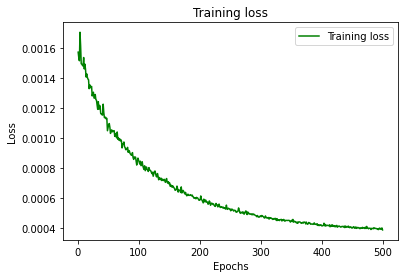

In [ ]:
losst=[]
itertion=[]

for i in range(1,n_iter+1):
    (inputs,targets)=gen_pair(batch_size)
    # print(inputs[0].shape, len(targets))
    loss = siamese_model.train_on_batch(inputs,targets)
    losst.append(loss)
    itertion.append(i)
    # accuracy.append(loss[1])
    print("iteration: ",i,loss)



plt.plot(itertion, losst, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
    

In [ ]:
testing_folder="/content/testing/"
correct_predictions = 0
reference_imgs =  np.expand_dims(X_train.reshape(500, 110, 110),axis=3)

for img in glob.glob(testing_folder+"/**"):
  true_label = int(img.split("/")[-1])
  # print(true_label)
  for image in glob.glob(img + "/*"):
    print(image)
    to_recog = np.asarray(PIL.Image.open(image).convert('L'))
    to_recog =  np.expand_dims(to_recog[10:120,10:120],axis=2)
    to_recog_arr = [to_recog for _ in range(X_train.shape[0]*X_train.shape[1])]
    to_recog_stack = np.stack(to_recog_arr, axis = 0)
    # print(to_recog_stack.shape , reference_imgs.shape)

    preds = list(siamese_model.predict([reference_imgs,to_recog_stack]).flatten())
    max_index = preds.index(max(preds))
    prediction = (int(max_index/X_train.shape[1]))
    if(prediction+1 == true_label):
      correct_predictions += 1
      print("Correctly predicted!","predicted class:",prediction+1,"GroundTruth class:",true_label)
  
print(correct_predictions, " is number of correct recognitions out of 100 random images.")

/content/testing/075/2.bmp
Correctly predicted! predicted class: 75 GroundTruth class: 75
/content/testing/050/6.bmp
Correctly predicted! predicted class: 50 GroundTruth class: 50
/content/testing/099/5.bmp
Correctly predicted! predicted class: 99 GroundTruth class: 99
/content/testing/077/4.bmp
Correctly predicted! predicted class: 77 GroundTruth class: 77
/content/testing/076/1.bmp
Correctly predicted! predicted class: 76 GroundTruth class: 76
/content/testing/078/5.bmp
Correctly predicted! predicted class: 78 GroundTruth class: 78
/content/testing/097/1.bmp
Correctly predicted! predicted class: 97 GroundTruth class: 97
/content/testing/008/5.bmp
Correctly predicted! predicted class: 8 GroundTruth class: 8
/content/testing/069/3.bmp
Correctly predicted! predicted class: 69 GroundTruth class: 69
/content/testing/079/3.bmp
Correctly predicted! predicted class: 79 GroundTruth class: 79
/content/testing/039/2.bmp
Correctly predicted! predicted class: 39 GroundTruth class: 39
/content/tes